In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [39]:
import numpy as np
import torchvision
from torchvision import datasets, transforms


X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0], 
                np.where(X_train.targets == 1)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0])


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True, pin_memory=True)

In [40]:

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0], 
                np.where(X_test.targets == 1)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0])


X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=128, shuffle=True)

In [45]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 384 * 7 * 7)
        x = self.classifier(x)
        return x


In [46]:
device = torch.device("cpu")
model = AlexNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [47]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 94655686


In [48]:
best_accuracy = 0
best_model = None

train_losses = []
test_losses = []

for epoch in range(10):
    model.train()
    train_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()

    print(f"Epoch {epoch + 1}/{10}")
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  9.59it/s]


Epoch 1/10
Train Loss: 0.0015, Test Loss: 0.0001, Accuracy: 99.57%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  8.64it/s]


Epoch 2/10
Train Loss: 0.0003, Test Loss: 0.0001, Accuracy: 99.47%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  9.55it/s]


Epoch 3/10
Train Loss: 0.0002, Test Loss: 0.0001, Accuracy: 99.57%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  8.76it/s]


Epoch 4/10
Train Loss: 0.0002, Test Loss: 0.0001, Accuracy: 99.68%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  9.53it/s]


Epoch 5/10
Train Loss: 0.0002, Test Loss: 0.0001, Accuracy: 99.62%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  9.58it/s]


Epoch 6/10
Train Loss: 0.0002, Test Loss: 0.0001, Accuracy: 99.72%


100%|███████████████████████████████████████████| 48/48 [00:04<00:00,  9.62it/s]


Epoch 7/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.54%


100%|███████████████████████████████████████████| 48/48 [00:05<00:00,  8.91it/s]


Epoch 8/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.64%


100%|███████████████████████████████████████████| 48/48 [00:04<00:00,  9.63it/s]


Epoch 9/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.68%


100%|███████████████████████████████████████████| 48/48 [00:04<00:00,  9.65it/s]

Epoch 10/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.68%


In [49]:
print(f"Best Accuracy: {best_accuracy:.2f}%")
torch.save(best_model, "alexnet mnist 0-5.pth")

Best Accuracy: 99.72%


/tmp/ipykernel_8678/4168391176.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


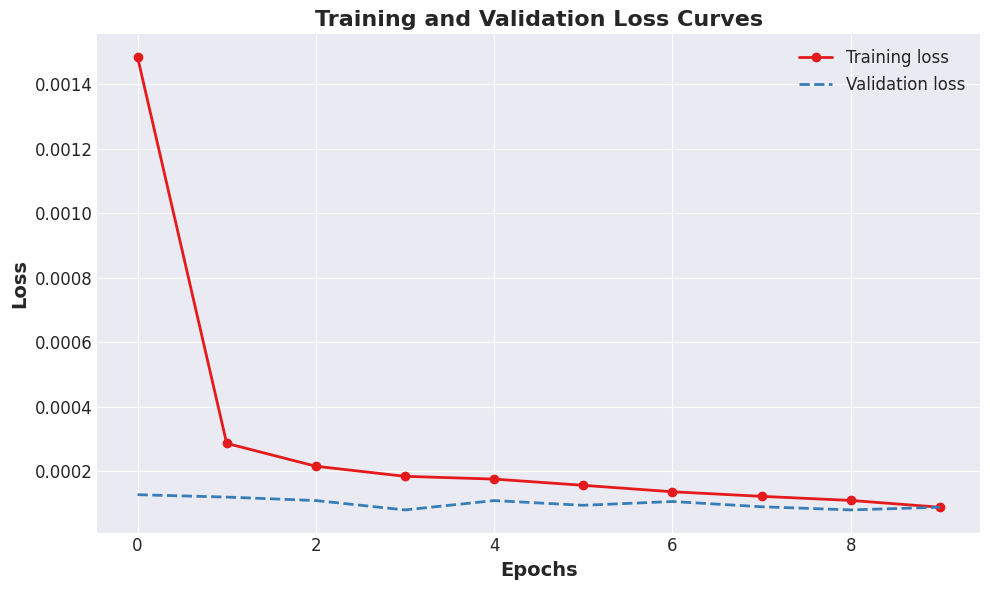

In [50]:
import matplotlib.pyplot as plt

# Use a professional style
plt.style.use('seaborn-darkgrid')

# Create a color palette
color_palette = plt.get_cmap('Set1')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both the curves simultaneously with enhanced aesthetics
ax.plot(train_losses, color=color_palette(0), marker='o', linestyle='-', linewidth=2, label='Training loss')
ax.plot(test_losses, color=color_palette(1), marker='', linestyle='--', linewidth=2, label='Validation loss')

# Naming the x-axis, y-axis and the whole graph with enhanced font properties
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax.set_title("Training and Validation Loss Curves", fontsize=16, fontweight='bold')

# Displaying the legend with larger font size
ax.legend(fontsize=12)

# Enhance tick visibility and size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the plot for better layout
plt.tight_layout()

# Saving the graph in high quality
plt.savefig("alexnet mnist 0-5 loss curve.png", dpi=300)

# Displaying the graph
plt.show()
